# ML Models and Performance
This notebook contains 5 models and their performance (accuracy, precision, recall, F1 score in Table 3 of the paper) as well as UMAP embedding and visualization (Figure 5 in the paper) based on the same model features.

In [80]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm

import umap
from matplotlib import pyplot as plt

import xgboost as xgb

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import SMOTE

import con_score

### Data

In [81]:
df = pd.read_csv("../output/Survivor/final_vote_history.csv")
castaways = pd.read_csv("../output/Survivor/final_castaways.csv")

In [82]:
le1 = LabelEncoder()
le1.fit(df['castaway_uid'].unique().tolist() + df['vote_uid'].unique().tolist())
df['castaway_encoded'] = le1.transform(df['castaway_uid'])
df['vote_encoded'] = le1.transform(df['vote_uid'])

Set Maximum Episodes for `4_Survivor_EpisodicAccuracy.ipynb` graphic

In [83]:
# max_epi = 8
#df = df[df.episode <= max_epi]

Clip final episodes into episode 12

In [84]:
df_grouped = df.copy()
df_grouped['episode'] = df_grouped['episode'].apply(lambda x: x if x <= 12 else 12)

In [85]:
df_grouped.shape

(4239, 28)

In [86]:
df_grouped.castaway_uid.nunique()   

741

### CON Score

In [87]:
con_scores_df = con_score.calculate_CON_multiorder1(df_grouped)

In [88]:
con_scores_df_1st = con_scores_df.groupby(['castaway_uid', 'episode']).agg({'1st_order_CON_score': 'sum'}).reset_index()
con_scores_df_2nd = con_scores_df.groupby(['castaway_uid', 'episode']).agg({'2nd_order_CON_score': 'sum'}).reset_index()
con_scores_df_lrg = con_scores_df.groupby(['castaway_uid', 'episode']).agg({'full_CON_score': 'sum'}).reset_index()
con_scores_df_pr = con_scores_df.groupby(['castaway_uid', 'episode']).agg({'pagerank': 'sum'}).reset_index()
con_scores_df_cn = con_scores_df.groupby(['castaway_uid', 'episode']).agg({'closeness': 'sum'}).reset_index()
con_scores_df_id = con_scores_df.groupby(['castaway_uid', 'episode']).agg({'in_degree': 'sum'}).reset_index()
con_scores_df_od = con_scores_df.groupby(['castaway_uid', 'episode']).agg({'out_degree': 'sum'}).reset_index()

In [89]:
con_matrix_1st = con_scores_df_1st.pivot(index='castaway_uid', columns='episode', values='1st_order_CON_score')
con_matrix_1st.columns = [f"1storder_{col}" for col in con_matrix_1st.columns]
con_matrix_1st = con_matrix_1st.fillna(0)

con_matrix_2nd = con_scores_df_2nd.pivot(index='castaway_uid', columns='episode', values='2nd_order_CON_score')
con_matrix_2nd.columns = [f"2ndorder_{col}" for col in con_matrix_2nd.columns]
con_matrix_2nd = con_matrix_2nd.fillna(0)

con_matrix_lrg = con_scores_df_lrg.pivot(index='castaway_uid', columns='episode', values='full_CON_score')
con_matrix_lrg.columns = [f"CON_{col}" for col in con_matrix_lrg.columns]
con_matrix_lrg = con_matrix_lrg.fillna(0)

pr_matrix = con_scores_df_pr.pivot(index='castaway_uid', columns='episode', values='pagerank')
pr_matrix.columns = [f"pagerank_{col}" for col in pr_matrix.columns]
pr_matrix = pr_matrix.fillna(0)

cn_matrix = con_scores_df_cn.pivot(index='castaway_uid', columns='episode', values='closeness')
cn_matrix.columns = [f"closeness_{col}" for col in cn_matrix.columns]
cn_matrix = cn_matrix.fillna(0)

id_matrix = con_scores_df_id.pivot(index='castaway_uid', columns='episode', values='in_degree')
id_matrix.columns = [f"indegree_{col}" for col in id_matrix.columns]
id_matrix = id_matrix.fillna(0)

od_matrix = con_scores_df_od.pivot(index='castaway_uid', columns='episode', values='out_degree')
od_matrix.columns = [f"outdegree_{col}" for col in od_matrix.columns]
od_matrix = od_matrix.fillna(0)

In [90]:
con_matrix_2nd = con_matrix_2nd.reindex(con_matrix_1st.index)
con_matrix_lrg = con_matrix_lrg.reindex(con_matrix_1st.index)
pr_matrix = pr_matrix.reindex(con_matrix_1st.index)
cn_matrix = cn_matrix.reindex(con_matrix_1st.index)
od_matrix = od_matrix.reindex(con_matrix_1st.index)
id_matrix = id_matrix.reindex(con_matrix_1st.index)

In [91]:
combined_matrix = pd.concat([con_matrix_1st, con_matrix_2nd, con_matrix_lrg, 
                             pr_matrix, cn_matrix, od_matrix, id_matrix
                             ], axis=1)
matrix_df_combined = combined_matrix.reset_index()

In [92]:
X = matrix_df_combined.iloc[:, 1:].to_numpy()

In [93]:
X.shape

(759, 84)

In [94]:
with open("../output/Survivor/Survivor_con_matrix_np.pkl", "wb") as f:
    pickle.dump(X, f)

Create true labels

In [95]:
castaway_dict = castaways.set_index('castaway_uid').to_dict()['result']
castaway_results = [castaway_dict[castaway] for castaway in matrix_df_combined['castaway_uid']]
results_df = pd.DataFrame({'result': castaway_results})
results_df['result_quantile'] = pd.qcut(results_df['result'].rank(method='first'), q=[0, 0.2, 0.8, 1], labels=False)
y = np.array(results_df['result_quantile'].astype(int))

In [96]:
np.bincount(y)

array([152, 455, 152], dtype=int64)

In [97]:
result_quantile_counts = results_df.value_counts('result_quantile')
print(result_quantile_counts)

result_quantile
1    455
0    152
2    152
Name: count, dtype: int64


### Training & Test Sets

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

In [99]:
np.bincount(y_train)

array([108, 327,  96], dtype=int64)

SMOTE

In [100]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Train models

In [101]:
models = {
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42),
    "SupportVectorClassifier-LINEAR": SVC(random_state=42, kernel='linear'),
    "XGBClassifier": xgb.XGBClassifier(random_state=42),
}

results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

predictions, saved_models = [], {}
for name, model in tqdm(models.items()):
    model.fit(X_train_smote, y_train_smote)
    saved_models[name] = model
    y_pred = model.predict(X_test)
    predictions.append(y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    results["Model"].append(name)
    results["Accuracy"].append(accuracy)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["F1-Score"].append(f1)

100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


In [102]:
np.bincount(predictions[0])

array([ 46, 138,  44], dtype=int64)

In [103]:
results = pd.DataFrame(results)
display(results.sort_values('Accuracy', ascending=False))
results.to_csv("../output/Survivor/Survivor_CON_score_ML_results.csv")

,Model,Accuracy,Precision,Recall,F1-Score
4,XGBClassifier,0.763158,0.730392,0.717634,0.722611
2,RandomForestClassifier,0.750000,0.710562,0.708198,0.708181
0,GradientBoostingClassifier,0.732456,0.693127,0.676170,0.681331
3,SupportVectorClassifier-LINEAR,0.719298,0.666906,0.655168,0.658583
1,DecisionTreeClassifier,0.684211,0.637765,0.595982,0.609807


### UMAP Visualization

In [104]:
#results_df['result_quantile1'] = pd.qcut(results_df['result'].rank(method='first'), q=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=[0,1,2,3,4])
#y1 = np.array(results_df['result_quantile1'].astype(int)) # why are there 5 quantiles?? is that why there are 5 clusters in the UMAP vis? doesn't seem right
#color_map1 = {0: 'brown', 1: 'orange', 2: 'red', 3: 'green', 4: 'purple'}
#np.bincount(y1)

In [105]:
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=75, spread=15, min_dist=0.5, metric='euclidean')
embedding = umap_reducer.fit_transform(X, y=y)

C:\Users\walaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1394: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
C:\Users\walaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


### UMAP Visualization

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


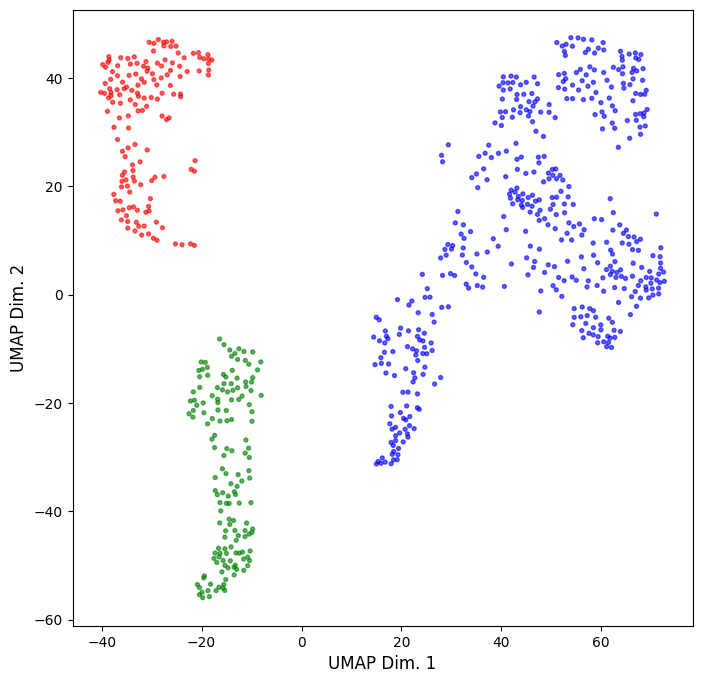

In [106]:
plt.figure(figsize=(8, 8))

color_map = {0: 'red', 1: 'blue', 2: 'green'}
colors = [color_map[label] for label in y]
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors,  s=8, alpha=0.6)

plt.xlabel("UMAP Dim. 1", fontsize=12)
plt.ylabel("UMAP Dim. 2", fontsize=12)
plt.savefig("../output/Survivor/Survivor_CON_UMAP.eps", format='eps')
plt.show()

In [107]:
full_results_dict = {castaway: castaway_dict[castaway] for castaway in matrix_df_combined['castaway_uid']}

In [108]:
with open("../output/Survivor/Survivor_outcome_dict.pkl", "wb") as f:
    pickle.dump(full_results_dict, f)

## Feature Importance

In [109]:
model = models['RandomForestClassifier']
feature_names = matrix_df_combined.iloc[:, 1:].columns
feature_importance = pd.DataFrame({'Feature': feature_names,  'Importance': model.feature_importances_}).sort_values(by='Importance', ascending=False)

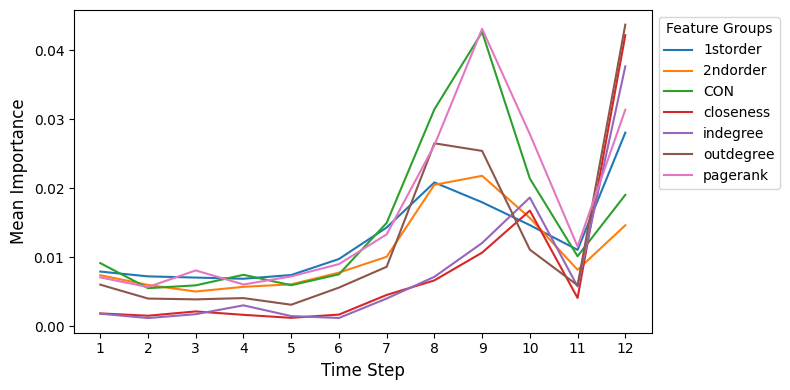

In [110]:
feature_importance['Feature_Group'] = feature_importance['Feature'].str.split('_').str[0]
feature_importance['Time_Step'] = feature_importance['Feature'].str.split('_').str[1]

group_time_mean_importance = feature_importance.groupby(['Feature_Group', 'Time_Step'], as_index=False)['Importance'].mean()

time_step_importance = group_time_mean_importance.pivot(index='Time_Step', columns='Feature_Group', values='Importance')
time_step_importance.index = time_step_importance.index.astype(float).astype(int)
time_step_importance = time_step_importance.sort_index(ascending=True)

plt.figure(figsize=(8, 4))
for group in time_step_importance.columns:
    plt.plot(time_step_importance.index, time_step_importance[group], label=group)

plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Mean Importance', fontsize=12)
plt.xticks(ticks=range(1, 13))  
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Feature Groups")
plt.grid(False)
plt.tight_layout()
plt.savefig("../output/Survivor/Survivor_fi_time_plot.svg", format='svg')
plt.show()

In [111]:
max_importance = feature_importance.groupby('Feature_Group', as_index=False)['Importance'].max()
max_importance = max_importance.sort_values(by='Importance', ascending=False)
display(max_importance)

,Feature_Group,Importance
5,outdegree,0.043709
6,pagerank,0.043107
2,CON,0.042630
3,closeness,0.042189
4,indegree,0.037669
0,1storder,0.028060
1,2ndorder,0.021813


,Feature_Group,Importance
6,pagerank,0.196750
2,CON,0.181356
0,1storder,0.153360
5,outdegree,0.148218
1,2ndorder,0.129067
4,indegree,0.096020
3,closeness,0.095229


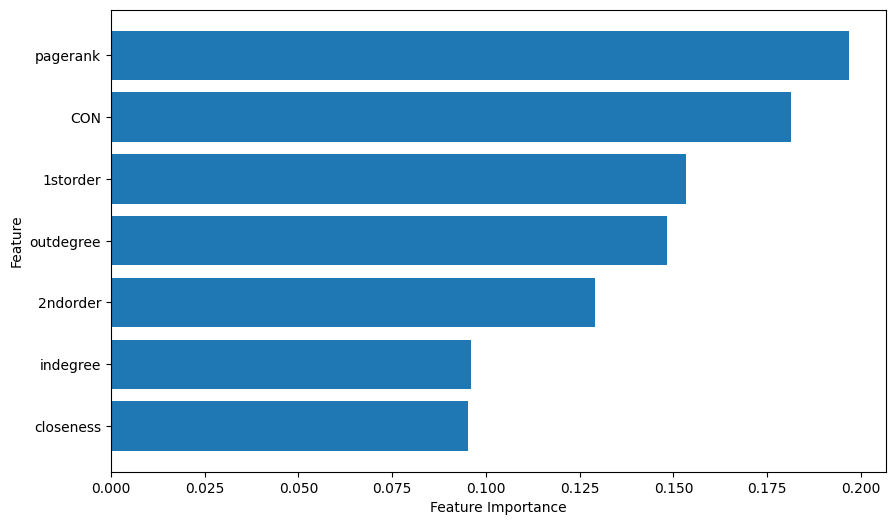

In [112]:
feature_importance['Feature_Group'] = feature_importance['Feature'].str.split('_').str[0]
aggregated_importance = feature_importance.groupby('Feature_Group', as_index=False)['Importance'].sum()
aggregated_importance = aggregated_importance.sort_values(by='Importance', ascending=False)
display(aggregated_importance)
plt.figure(figsize=(10, 6))
plt.barh(aggregated_importance['Feature_Group'], aggregated_importance['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  
plt.savefig("../output/Survivor/Survivor_fi_bar_plot.svg", format='svg')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


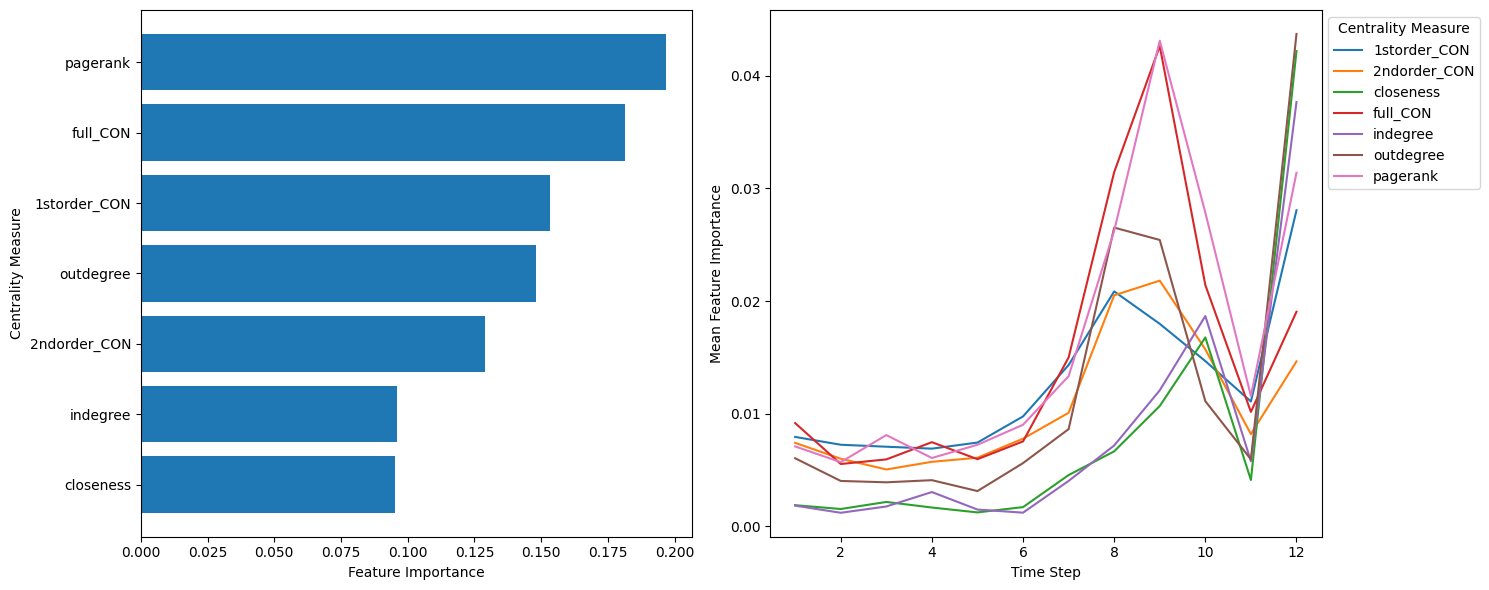

In [113]:
feature_group_mapping = {"2ndorder": "2ndorder_CON", "1storder": "1storder_CON","CON": "full_CON"}

feature_importance['Feature_Group'] = feature_importance['Feature'].str.split('_').str[0]
feature_importance['Feature_Group'] = feature_importance['Feature_Group'].replace(feature_group_mapping)
aggregated_importance = feature_importance.groupby('Feature_Group', as_index=False)['Importance'].sum()
aggregated_importance = aggregated_importance.sort_values(by='Importance', ascending=False)

feature_importance['Time_Step'] = feature_importance['Feature'].str.split('_').str[1]

group_time_mean_importance = feature_importance.groupby(['Feature_Group', 'Time_Step'], as_index=False)['Importance'].mean()

time_step_importance = group_time_mean_importance.pivot(index='Time_Step', columns='Feature_Group', values='Importance')

time_step_importance.index = time_step_importance.index.astype(float).astype(int)
time_step_importance = time_step_importance.sort_index(ascending=True)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

axs[0].barh(aggregated_importance['Feature_Group'], aggregated_importance['Importance'])
axs[0].set_xlabel('Feature Importance')
axs[0].set_ylabel('Centrality Measure')
axs[0].invert_yaxis()

for group in time_step_importance.columns:
    axs[1].plot(time_step_importance.index, time_step_importance[group], label=group)
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Mean Feature Importance')
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), title="Centrality Measure")
axs[1].grid(False)

plt.tight_layout()
plt.savefig("../output/Survivor/Survivor_combined_plots.eps", format='eps')
plt.show()

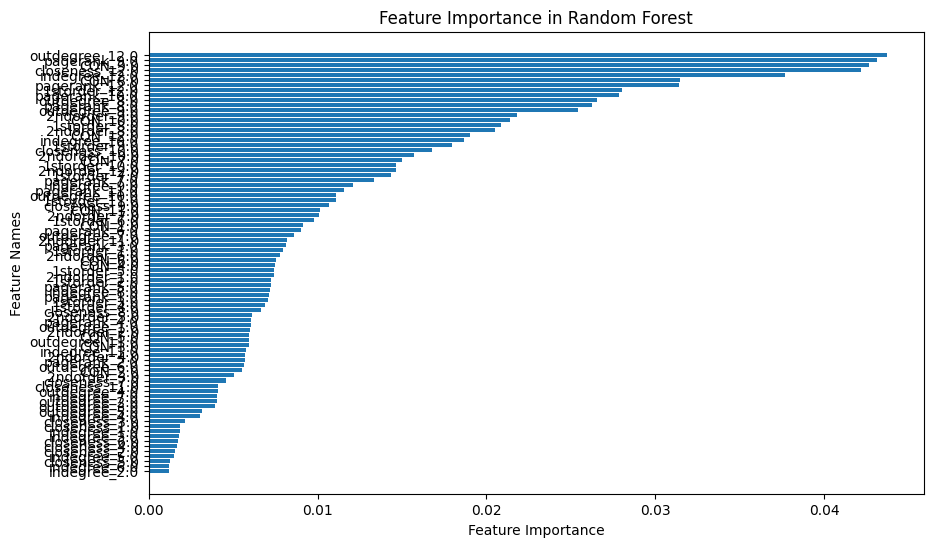

In [114]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()  
plt.show()